In [ ]:
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras import backend as K
from keras.losses import binary_crossentropy
from numpy import reshape
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [ ]:
image_size = x_train.shape[1]
x_train = reshape(x_train, [-1, image_size, image_size, 1])
x_test = reshape(x_test, [-1, image_size, image_size, 1])

In [ ]:
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
latent_dim = 8

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [ ]:
input_img = Input(shape=(image_size, image_size, 1),)

In [ ]:
h=Conv2D(16,kernel_size=3,activation='relu',padding='same',strides=2)(input_img)
enc_ouput=Conv2D(32,kernel_size=3,activation='relu',padding='same',strides=2)(h)


In [ ]:
shape = K.int_shape(enc_ouput)
x = Flatten()(enc_ouput)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [ ]:

encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 16)           160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 32)             4640      ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 1568)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x=Conv2DTranspose(32, kernel_size=3,activation='relu',strides=2,padding='same')(x)
x=Conv2DTranspose(16, kernel_size=3,activation='relu',strides=2,padding='same')(x)
dec_output=Conv2DTranspose(1, kernel_size=3, activation='relu',padding='same')(x)


In [ ]:
decoder = Model(latent_inputs, dec_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 8)]               0         
                                                                 
 dense_1 (Dense)             (None, 1568)              14112     
                                                                 
 reshape (Reshape)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 32)        9248      
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        4624      
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         145 

In [ ]:
outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

In [ ]:
reconst_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconst_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconst_loss + kl_loss)

In [ ]:
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 8),                  30176     ['input_1[0][0]']             
                              (None, 8),                                                          
                              (None, 8)]                                                          
                                                                                                  
 decoder (Functional)        (None, 28, 28, 1)            28129     ['encoder[0][2]']             
                                                                                                

In [ ]:
vae.fit(x_train,epochs=20,batch_size=128,shuffle=True,validation_data=(x_test,None))

Epoch 1/20
469/469 [==============================] - 15s 8ms/step - loss: 185.6709 - val_loss: 152.6142
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 149.0474 - val_loss: 142.8872
Epoch 3/20
469/469 [==============================] - 4s 9ms/step - loss: 141.0977 - val_loss: 134.5671
Epoch 4/20
469/469 [==============================] - 4s 8ms/step - loss: 136.5984 - val_loss: 141.1543
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 132.0811 - val_loss: 127.3668
Epoch 6/20
469/469 [==============================] - 4s 8ms/step - loss: 129.2284 - val_loss: 129.1530
Epoch 7/20
469/469 [==============================] - 4s 7ms/step - loss: 127.3609 - val_loss: 128.5590
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 125.7790 - val_loss: 123.6505
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 124.2508 - val_loss: 127.8892
Epoch 10/20
469/469 [==============================] - 4s 8ms/s

In [ ]:
z_mean, _, _ = encoder.predict(x_test)
decoded_imgs = decoder.predict(z_mean)

313/313 [==============================] - 1s 2ms/step


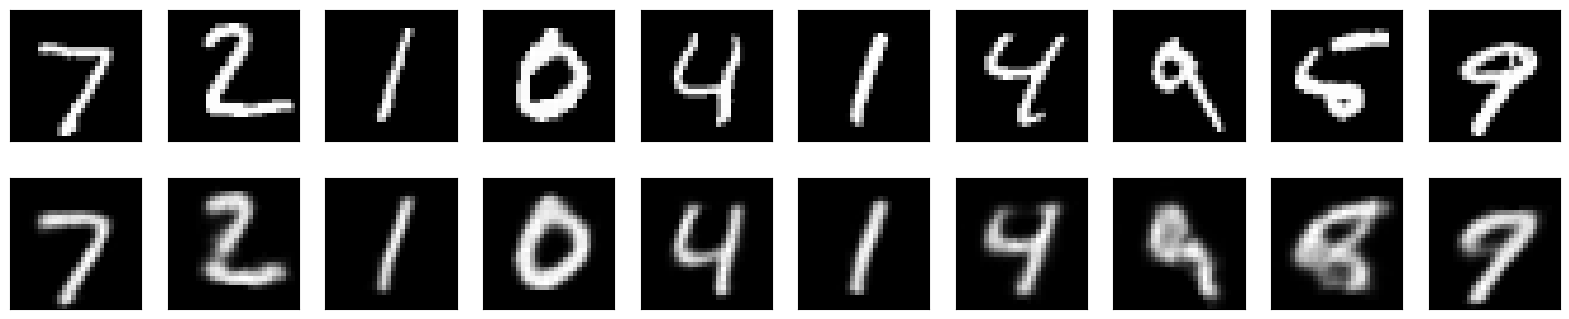

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(10):
	plt.gray()
	ax = plt.subplot(2, n, i+1)
	plt.imshow(x_test[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)

	ax = plt.subplot(2, n, i +1+n)
	plt.imshow(decoded_imgs[i].reshape(28, 28))
	ax.get_xaxis().set_visible(False)
	ax.get_yaxis().set_visible(False)
plt.show()
